<a href="https://colab.research.google.com/github/borbysh/quantum-barren-plateaus/blob/main/Tutorials/Barren_pennylane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
%matplotlib inline
!pip install pennylane==0.38

In [41]:
import sys
sys.path.append('..')
import pennylane.numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

In [42]:
def global2local( Hamiltonian ):

    num_wires = len(Hamiltonian.wires)

    coeff = []
    ops   = []

    coeff_local = Hamiltonian.coeffs

    for i, hamiltonian in enumerate(Hamiltonian.ops):

        if int(hamiltonian.num_wires)== -1 or int(hamiltonian.num_wires)==1:
            ops.append( qml.Identity(range(num_wires)) )
            coeff.append( coeff_local[i] )

        else:
            pauli_local = hamiltonian.obs

            for pauli in pauli_local:
                ops.append( pauli )
                coeff.append( coeff_local[i]/num_wires  )

            ops.append( qml.Identity(range(num_wires)) )
            coeff.append( coeff_local[i]*(num_wires - hamiltonian.num_wires)/num_wires )

    return qml.Hamiltonian( np.array(coeff), ops).simplify()

def test_hamiltonian( num_wires ):

    Paulis = qml.Hamiltonian( [0.5, 0.5], [qml.Identity(0), qml.PauliZ(0) ] )
    for i in range(1,num_wires):
        zero = qml.Hamiltonian( [0.5, 0.5], [qml.Identity(i), qml.PauliZ(i) ] )
        Paulis = Paulis@zero

    Hamiltonian = qml.Hamiltonian( list(-Paulis.coeffs)+[1], Paulis.ops+[ qml.Identity(0) ] )

    return Hamiltonian.simplify()


def test_hamiltonian_2( num_wires, coeff ):

    obs = [ qml.pauli.string_to_pauli_word(num_wires*'X'),
            qml.pauli.string_to_pauli_word(num_wires*'Y') ,
            qml.pauli.string_to_pauli_word(num_wires*'Z') ]

    return qml.Hamiltonian(coeff, obs)

In [43]:
def VQE( Hamiltonian,
            ansatz,
            params,
            optimizer,
            max_iterations = 100,
            conv_tol       = None,
            device         = "default.qubit",
            shots          = None,
            callback       = None
             ):

    num_wires = len(Hamiltonian.wires)
    dev = qml.device(device, wires=num_wires, shots=shots)
    @qml.qnode(dev)
    def cost_func(params):
        ansatz(params)
        return qml.expval(Hamiltonian)

    # store the values of the cost function
    energy_k = [cost_func(params)]

    # store the values of the circuit parameter
    params_k = [params]

    for n in range(max_iterations):
        params, prev_energy = optimizer.step_and_cost(cost_func, params)

        energy_k.append(cost_func(params))
        params_k.append(params)

        if callback is not None:
            callback(params)

        # if n % 2 == 0:
            # print(f"Step = {n},  Energy = {energy_k[-1]:.8f} Ha")

        if conv_tol is not None:
            conv = np.abs(energy_k[-1] - prev_energy)
            if conv <= conv_tol:
                break

    return params_k, energy_k

In [44]:
def cnot_layer( n_qbits, n_cnot='Full_connect' ):
    """
    Create an entangling layer circuit.

    Input:
    n_qbits (int): Number of qubits of the circuit
    n_cnot (int, list, str):  Specify the type of entangling layer:
        str = 'Full_connect' ; that means the circuit is full fill with CNOT's gates.
        int = Number of CNOT's to implement from the first qubit to the last of the first half of qubits in descendet order.
        list= List of pair values e.g. [[1,2], [7,6]], first element of each list is control qubit e.g 1, 7 and the second the target qubit e.g 2, 6.

    Output:
    (QuantumCircuit): Entangling layer
    """
    sysA = int( len(n_qbits)/2 )

    if isinstance( n_cnot, int ):
        for i in range( n_cnot ):
            qml.CNOT( wires=[ n_qbits[i] , n_qbits[i + sysA] ] )

    elif n_cnot == 'Full_connect':
        for i in range( sysA ):
            qml.CNOT( wires=[ n_qbits[i] , n_qbits[i + sysA] ] )

    else:
        n_cnot = np.shape( n_cnot )[0]
        for i in range( n_cnot ):
            qml.CNOT( wires=[ n_cnot[i][0] , n_cnot[i][1] ] )


def SCL( params, n_qbits, n_qbits_crz=2, deep=1 ):
    """
    Schmidt Coefficient Layer (SCL) that performs a Schmidth decomposition or a basis change.

    Input:
    params (list):      Parameters to initialize the circuit.
    n_qbits (iterable): Qubits of the layer.
    n_qbits_crz (list): Qubits in the control Z gate. Default (2) is for 1 control qubit and 1 target qubit.
    deep (int):         Times that the circuit is repeated.
    name (str):         Name of the circuit.

    Output:
    (QuantumCircuit): A Parametric Quantum Circuit.
    """

    qubits= len( n_qbits )
    par = -(qubits % 2) # parity test: -1 for odd, 0 for even

    for i in range( qubits ):
        qml.RY( params[i], wires=[ n_qbits[i] ] )

    cc = -1
    for _ in range( 1, deep+1 ):

        for i in range( 0 , qubits + par, n_qbits_crz ):
            for l in range( 1, n_qbits_crz ):
                cc += 1
                qml.CZ( wires=[ n_qbits[i], n_qbits[i+l] ] )

        for i in range( qubits ):
            cc += 1
            qml.RY( params[ qubits + cc ], wires=[ n_qbits[i] ] )

        for i in range( 1, qubits-1, n_qbits_crz ):
            for l in range( 1, n_qbits_crz ):
                cc += 1
                qml.CZ( wires=[ n_qbits[i], n_qbits[i+l] ] )
                qml.RY( params[ qubits + cc ], wires=[ n_qbits[i] ] )
                qml.RY( params[ qubits + cc ], wires=[ n_qbits[i + l] ] )


def ansatz_constructor( n_qbits, unitaries=[SCL, SCL, SCL], n_qb_crz=[2,2,2], deep= [1,1,1], n_cnot='Full_connect' ):
    """
    The State Efficient Ansatz parametric quantum circuit (PQC) that perform a schmith decomposition, entanglement and a basis change.
    The ansatz circuit is made of three PQC's and one entangling layer.
    The input parameters will define this four gates of the ansatz circuit U_1, V, U_2 and U_3.

    Input:
    n_qbits (int):            Number of qubits.
    unitaries (list):         Containing the three PQC's that conform the SEA.
    n_qbits_crz (list):       Qubits in the control Z gate for each PQC. Default ([2,2,2]) is for 1 control qubit and 1 target qubit for each PQC.
    deep (list):              Times that each circuit is repeated.
    n_cnot (int, list, str):  Specify the type of entangling layer:
        str = 'Full_connect' ; that means the circuit is full fill with CNOT's gates.
        int = Number of CNOT's to implement from the first qubit to the last of the first half of qubits in descendet order.
        list= List of pair values e.g. [[1,2], [7,6]], first element of each list is control qubit e.g 1, 7 and the second the target qubit e.g 2, 6.

    Output:
    (QuantumCircuit): The State Efficient Ansatz parametric quantum circuit (PQC).
    """

    def circuit(params):
        unitaries[0]( params[0], range( int(n_qbits/2) ), n_qbits_crz=int(n_qb_crz[0]), deep=deep[0] )
        cnot_layer( range(n_qbits), n_cnot=n_cnot )
        unitaries[1]( params[1], range( int(n_qbits/2) ), n_qbits_crz=int(n_qb_crz[1]), deep=deep[1] )
        unitaries[2]( params[2], range( int(n_qbits/2), n_qbits ), n_qbits_crz=int(n_qb_crz[2]), deep=deep[2] )

    return circuit

We provides an early implementation of the local-global VQE and the State Efficient Ansatz for __Penylane__. We are going to optimize the following hamiltonian.

In [45]:
num_wires = 6
hamiltonian = test_hamiltonian_2( num_wires, [0,0,1] )
print( hamiltonian )

0 * (X(0) @ X(1) @ X(2) @ X(3) @ X(4) @ X(5)) + 0 * (Y(0) @ Y(1) @ Y(2) @ Y(3) @ Y(4) @ Y(5)) + 1 * (Z(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5))


Calculating the local Hamiltonian.

In [46]:
hamiltonian_local = global2local( hamiltonian )
print(hamiltonian_local)

0.0 * X(0) + 0.0 * X(1) + 0.0 * X(2) + 0.0 * X(3) + 0.0 * X(4) + 0.0 * X(5) + 0.0 * I(0) + 0.0 * Y(0) + 0.0 * Y(1) + 0.0 * Y(2) + 0.0 * Y(3) + 0.0 * Y(4) + 0.0 * Y(5) + 0.16666666666666666 * Z(0) + 0.16666666666666666 * Z(1) + 0.16666666666666666 * Z(2) + 0.16666666666666666 * Z(3) + 0.16666666666666666 * Z(4) + 0.16666666666666666 * Z(5)


/usr/local/lib/python3.11/dist-packages/pennylane/ops/op_math/prod.py:258: PennyLaneDeprecationWarning: Accessing the terms of a tensor product operator via op.obs is deprecated, please use op.operands instead.
  warnings.warn(


Creating the variational circuit.

In [47]:
def ansatz(params, num_layers=0):

    num_wires = len(params)//(2*num_layers+2)

    K = 0
    for i in range(num_layers):
        qml.broadcast( qml.RY, wires=range(num_wires), pattern='single', parameters=params[K:K+num_wires] )
        qml.broadcast( qml.RZ, wires=range(num_wires), pattern='single', parameters=params[K+num_wires:K+2*num_wires] )
        qml.broadcast( qml.CNOT, wires=range(num_wires), pattern='ring')
        K = K+2*num_wires

    qml.broadcast( qml.RY, wires=range(num_wires), pattern='single', parameters=params[K:K+num_wires] )
    qml.broadcast( qml.RZ, wires=range(num_wires), pattern='single', parameters=params[K+num_wires:K+2*num_wires] )

Choosing SPSA as optimizer.

In [48]:
optimizer_spsa = qml.SPSAOptimizer(maxiter=1000)
maxiter   = 300

It's a Signum optimizer

In [49]:
"""Signum optimizer"""
from numpy import sqrt, sign

#from .gradient_descent import GradientDescentOptimizer
from pennylane import GradientDescentOptimizer



class SignumOptimizer(GradientDescentOptimizer):
    r"""Gradient-descent optimizer with adaptive learning rate, first and second moment.

    Adaptive Moment Estimation uses a step-dependent learning rate,
    a first moment :math:`a` and a second moment :math:`b`, reminiscent of
    the momentum and velocity of a particle:

    .. math::
        x^{(t+1)} = x^{(t)} - \eta^{(t+1)} \frac{a^{(t+1)}}{\sqrt{b^{(t+1)}} + \epsilon },

    where the update rules for the two moments are given by

    .. math::
        a^{(t+1)} &= \beta_1 a^{(t)} + (1-\beta_1) \nabla f(x^{(t)}),\\
        b^{(t+1)} &= \beta_2 b^{(t)} + (1-\beta_2) (\nabla f(x^{(t)}))^{\odot 2},\\
        \eta^{(t+1)} &= \eta \frac{\sqrt{(1-\beta_2^{t+1})}}{(1-\beta_1^{t+1})}.

    Above, :math:`( \nabla f(x^{(t-1)}))^{\odot 2}` denotes the element-wise square operation,
    which means that each element in the gradient is multiplied by itself. The hyperparameters
    :math:`\beta_1` and :math:`\beta_2` can also be step-dependent. Initially, the first and
    second moment are zero.

    The shift :math:`\epsilon` avoids division by zero.

    For more details, see `arXiv:1412.6980 <https://arxiv.org/abs/1412.6980>`_.

    Args:
        stepsize (float): the user-defined hyperparameter :math:`\eta`
        beta1 (float): hyperparameter governing the update of the first and second moment
        beta2 (float): hyperparameter governing the update of the first and second moment
        eps (float): offset :math:`\epsilon` added for numerical stability

    .. note::

        When using ``torch``, ``tensorflow`` or ``jax`` interfaces, refer to :doc:`Gradients and training </introduction/interfaces>` for suitable optimizers.

    """

    def __init__(self, stepsize=0.01, beta1=0.9, beta2=0.99):
        super().__init__(stepsize)
        self.beta1 = beta1
        self.beta2 = beta2
        self.accumulation = None



    def apply_grad(self, grad, args):
        r"""Update the variables args to take a single optimization step. Flattens and unflattens
        the inputs to maintain nested iterables as the parameters of the optimization.

        Args:
            grad (tuple[ndarray]): the gradient of the objective
                function at point :math:`x^{(t)}`: :math:`\nabla f(x^{(t)})`
            args (tuple): the current value of the variables :math:`x^{(t)}`

        Returns:
            list: the new values :math:`x^{(t+1)}`
        """
        args_new = list(args)

        if self.accumulation is None:
            self.accumulation = {"dx": [0] * len(args), "dx_sgn": [0] * len(args), "t": 0}

        self.accumulation["t"] += 1

        bias_correction1 = 1 - self.beta1 ** self.accumulation["t"]


        trained_index = 0
        for index, arg in enumerate(args):
            if getattr(arg, "requires_grad", False):
                self._update_accumulation(index, grad[trained_index])
                args_new[index] = arg + self.accumulation["dx"][index] / bias_correction1

                trained_index += 1

        return args_new


    def _update_accumulation(self, index, grad):
        r"""Update the moments.

        Args:
            index (int): the index of the argument to update
            grad (ndarray): the gradient for that trainable param
        """

        bias_correction2 = 1 - self.beta2 ** self.accumulation["t"]

        #bias_correction1 = 1 - self.beta1 ** self.accumulation["t"]

        previous_step = self.accumulation["dx"][index] #/ bias_correction1

        # update the step-sign correlator
        self.accumulation["dx_sgn"][index] = (
            self.beta2 * self.accumulation["dx_sgn"][index] + (1 - self.beta2) * sign(grad) * previous_step
        )

        cross_correlator = self.accumulation["dx_sgn"][index] / bias_correction2

        # Calculate the learning rate
        lr = self.beta1 * cross_correlator + sqrt((self.beta1 * cross_correlator)**2 + (1 - self.beta1**2) * self.stepsize**2)

        # update momentum
        self.accumulation["dx"][index] = (
            self.beta1 * self.accumulation["dx"][index] - lr * sign(grad)
        )


    def reset(self):
        """Reset optimizer by erasing memory of past steps."""
        self.accumulation = None


    @property
    def dx(self):
        """Returns estimated momentum"""
        return None if self.accumulation is None else self.accumulation["dx"]

    @property
    def dx_sgn(self):
        """Returns estimated cross-correlator"""
        return None if self.accumulation is None else self.accumulation["dx_sgn"]

    @property
    def t(self):
        """Returns accumulated timesteps"""
        return None if self.accumulation is None else self.accumulation["t"]

In [50]:
optimizer_signum = SignumOptimizer(stepsize=1e-2)
maxiter   = 300

In [51]:
optimizer_adam = qml.AdamOptimizer(stepsize=1e-2)

Defining a device.

In [52]:
dev = qml.device("default.qubit", wires=num_wires)
@qml.qnode(dev)
def cost_func(params):
    ansatz(params)
    return qml.expval(hamiltonian)

Runing the VQEs.

In [59]:
np.random.seed(100)
params_in = np.random.randn( 2*num_wires )*np.pi
params_out, energies_global_spsa = VQE( hamiltonian, ansatz, params_in, optimizer_spsa, shots=2**6, max_iterations=maxiter )

In [61]:
np.random.seed(100)
#params_in = np.random.randn( 2*num_wires )*np.pi
params_out, energies_global_signum = VQE( hamiltonian, ansatz, params_in, optimizer_signum, shots=2**6, max_iterations=maxiter )

In [62]:
np.random.seed(100)
#params_in = np.random.randn( 2*num_wires )*np.pi
params_out, energies_global_adam = VQE( hamiltonian, ansatz, params_in, optimizer_adam, shots=2**6, max_iterations=maxiter )

In [63]:
np.random.seed(100)
#params_in = np.random.randn( 2*num_wires )*np.pi
params_out, energies_local  = VQE( hamiltonian_local, ansatz, params_in, optimizer_spsa, shots=2**6, max_iterations=maxiter//2)
energies_global_from_local = [ cost_func(x) for x in params_out ]

In [64]:
np.random.seed(100)
params_in = np.random.randn( 6*num_wires )*np.pi
params_out, energies_global_after_local = VQE( hamiltonian, ansatz, params_out[-1], optimizer_spsa, shots=2**6, max_iterations=maxiter//2 )

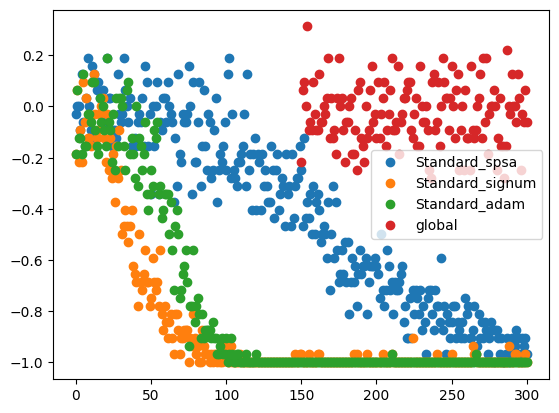

In [65]:
plt.plot( energies_global_spsa, 'o' )
plt.plot( energies_global_signum, 'o' )
#plt.plot( energies_global_from_local, 'o' )
plt.plot( energies_global_adam, 'o' )
plt.plot( range(maxiter//2,maxiter+1), energies_global_after_local, 'o' )
plt.legend([ 'Standard_spsa', 'Standard_signum',
            #'local',
             'Standard_adam', 'global'])


We also implement the Efficient State Ansatz.

In [ ]:
n_qbits = num_wires
reps    = 1
SEA = ansatz_constructor(n_qbits , deep=[reps,reps,reps])

num_params_SEA = ( reps +1 )*n_qbits + reps*(n_qbits - 2)

params_SEA = [ np.random.randn( num_params_SEA )*np.pi for _ in range(3) ]

In [ ]:
par, results_SEA = VQE(hamiltonian, SEA, params_SEA, optimizer_spsa, shots=2**6, max_iterations=maxiter)

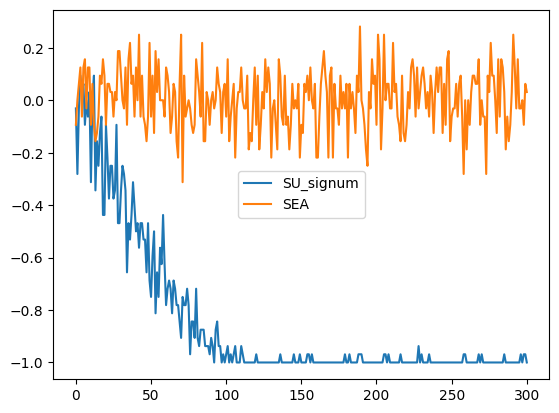

In [ ]:
plt.plot( energies_global_signum, label='SU_signum' )
plt.plot( results_SEA, label='SEA' )
plt.legend(  )

Our current implementation is not able to outperforme barren plateaus. We think that improve our VQE and the classical optimizer is mandatory to obtain better results. This is a first step to have this routines in Pennylane.